# Text-to-Image Diffusion model이란?

- 랜덤 노이즈로부터 노이즈를 조금씩 제거하면서 이미지를 생성하는 생성 모델입니다.
- 시작 노이즈가 달라지면(seed) 다른 이미지를 생성합니다.
- 입력 텍스트에 따르는 이미지를 생성합니다.
- 대표적인 Text-to-Image Diffusion model : DALL-E, Stable Diffusion, Imagen 등


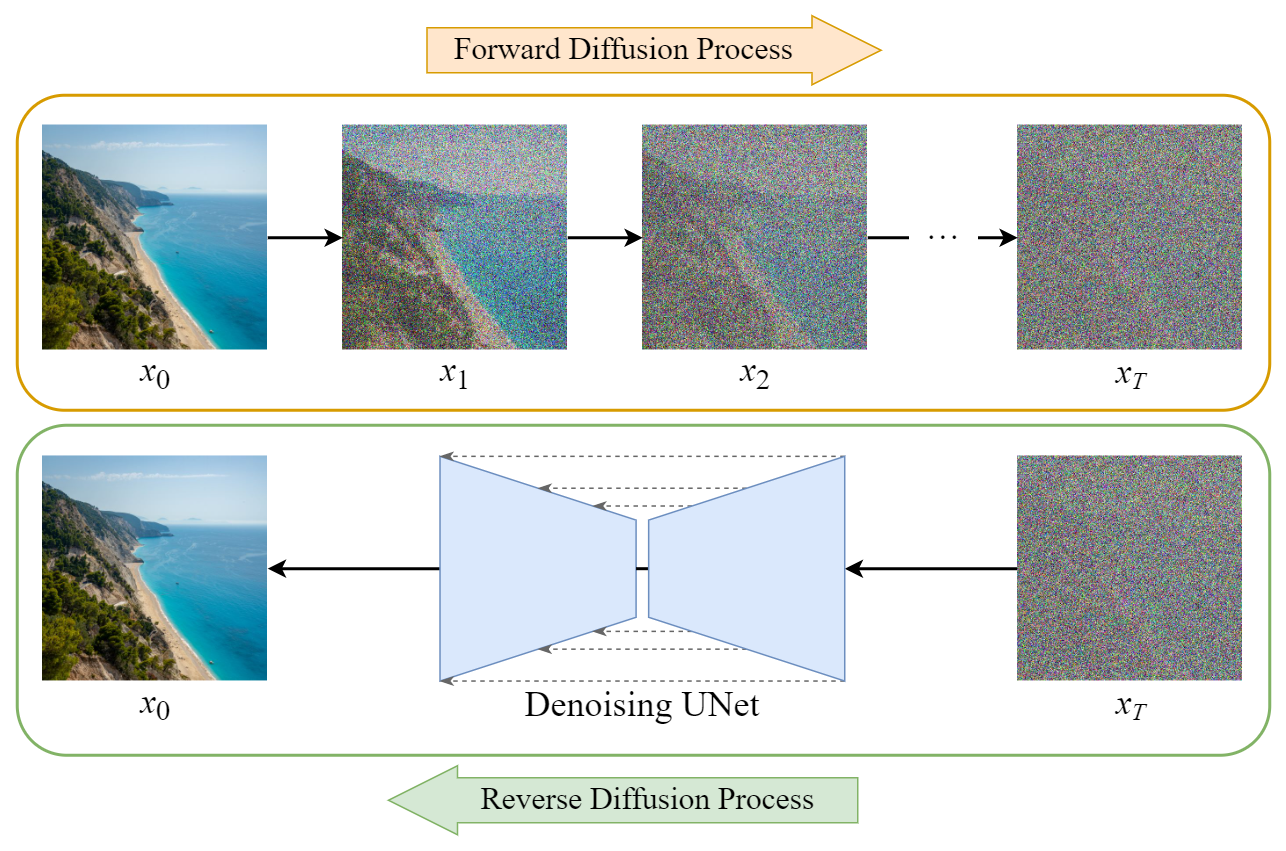

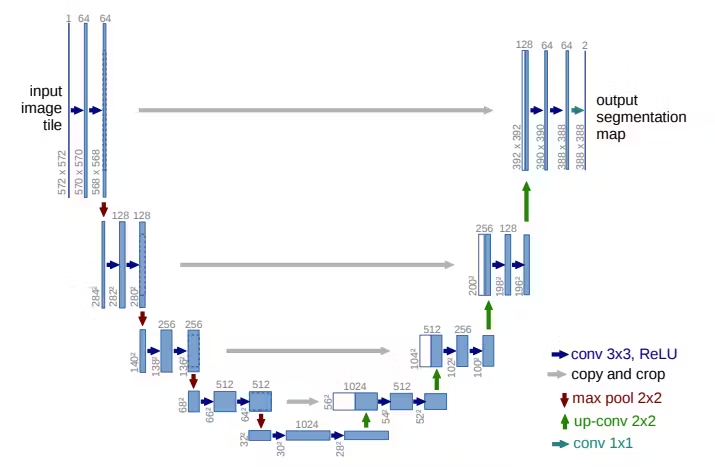

### 디퓨전 모델의 forward process, reverse process
- forward process : 학습 이미지에 잡음(노이즈)를 첨가하는 과정
- reverse process : 노이즈로부터 원래 학습 이미지를 복원하는 과정

- 추론 시 : 무작위 노이즈로부터 reverse process를 통해 이미지를 생성

# OpenAI DALL-E 2를 이용하여 이미지 생성하기

In [ ]:
# !pip install openai

In [ ]:
# 버전에러로 인한 버전 픽스
!pip install openai==0.28

In [ ]:
!pip show openai

Name: openai
Version: 0.28.0
Summary: Python client library for the OpenAI API
Home-page: https://github.com/openai/openai-python
Author: OpenAI
Author-email: support@openai.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, requests, tqdm
Required-by: llmx


## api_key 발급 받는법
1. https://openai.com/product 사이트로 접근 & 회원가입
2. 로그인 후 'API' 선택
3. 우측상단의 personal을 누른 뒤 View API keys 선택
4. create new secret key 사용
5. 'Billing hard limit has been reached' 라는 에러가 나올텐데, DALL-E API를 사용하는 경우 일정 금액을 충전해야 사용가능해짐
6. 다시 personal로 가서 Billing -> overview에 가서 충전
7. API key를 발급받은 후 api_key를 발급 받아 입력


In [ ]:
import openai
from PIL import Image
import requests
from io import BytesIO

# api_key를 개인별로 발급받아 입력합니다. (내 키로 바꿈. 원래 조교님 키가....)
openai.api_key = "APIKEY"
'''
1. prompt : 이미지에 대한 설명을 prompt에 입력합니다.
2. n : 한 번에 생성할 이미지의 개수를 설정합니다.
3. size : 이미지의 해상도를 결정합니다.
'''

response = openai.Image.create(
    prompt='a white siamese cat',
    n=2,
    size="512x512"
)
image_url = response['data'][0]['url']
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

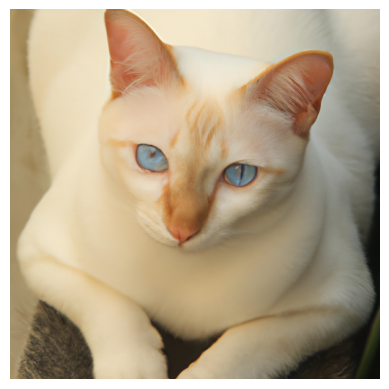

In [ ]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(img)
plt.show()

# Stable Diffusion을 이용하여 이미지 생성하기

## Diffusers 사용법 익히기

- diffusers란?
    - diffusion model을 쉽게 사용하기 위한 통합 라이브러리
    - pipe라는 구조로 high-level에서 쉽게 이미지를 생성할 수도, 내부 구조를 수정하여 customize도 가능
    - 다루기 쉽고 새로운 모델도 계속 추가되는 중

### Huggingface로부터 token 받아오기

- Huggingface 홈페이지 가입 후 settings-Access tokens에서 READ 용으로 token 발급받기

In [ ]:
%pip install huggingface_hub
%pip install diffusers
%pip install transformers
%pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.0 MB/s eta 0:00:00


In [ ]:
# diffusers에서 stable diffusion model을 사용하기 위해 token을 받아옵니다.
from huggingface_hub import login

login()

In [ ]:
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import torch

# diffusion model의 이미지 생성 과정이 pipe 안에서 전부 이루어집니다.
# 이번 실습에서는 stable diffusion 1.5를 사용
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

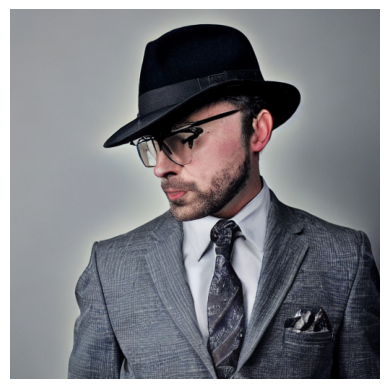

In [ ]:
prompt = "a man waring fedora"

# prompt : 이미지 생성 시 어떠한 이미지를 만들 지 문장으로 설명
# guidance scale : prompt가 주어졌을 때 이미지가 prompt를 얼마나 따를지를 결정합니다. 일반적으로 5~15 사이 사용
image = pipe(prompt, guidance_scale=7.5).images[0]
plt.axis('off')
plt.imshow(image)
plt.show()

### 시드값을 고정하여 같은 이미지 생성하기

  0%|          | 0/50 [00:00<?, ?it/s]

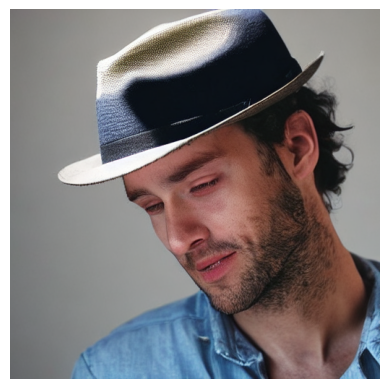

In [ ]:
prompt = "a man wearing fedora"
# generator를 사용하여 시드값 설정 : 1024
generator = torch.Generator("cuda").manual_seed(1024)
image = pipe(prompt, guidance_scale=7.5, generator=generator).images[0]

plt.axis('off')
plt.imshow(image)
plt.show()

# ControlNet을 사용하여 이미지 만들기
## ControlNet이란??
- 디퓨전 모델에 condition을 여러 개 넣어(text + scribble, canny, depth, normal, pose 등...) 조건부 이미지를 생성하는 모델
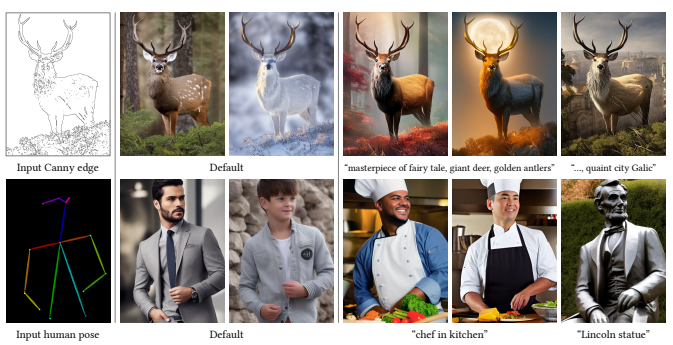

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

torch.cuda.empty_cache()

# diffusers에서 controlnet 모델을 불러옵니다.
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-scribble", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
from PIL import Image

# 고양이 스케치 사진을 불러옵니다.
scribble_image = Image.open('./scribble_cat.png')

In [ ]:
prompt = "a white siamese cat"

# pipeline에는 prompt, 스케치 이미지를 입력합니다.

output = pipe(
    prompt,
    scribble_image,
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

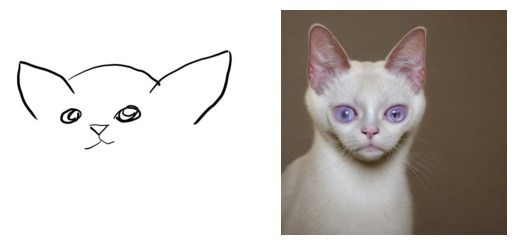

In [ ]:
# 스케치 이미지와 생성 결과물을 plot합니다.

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(scribble_image)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(output)
plt.show()

# Image Inpainting
- 마스크를 활용하여 조건부 이미지 생성하기

In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline
import PIL
import requests
from io import BytesIO

torch.cuda.empty_cache()

# inpainting pipeline 불러오기
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
pipe = pipe.to("cuda")

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


# url로부터 예시 이미지를 다운로드하고 512 x 512 크기로 맞추기
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

In [ ]:
prompt = "Face of a yellow cat, high resolution, sitting on a park bench"

# 파이프라인에는 프롬프트, 원본 이미지, 마스크 이미지를 입력합니다.
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

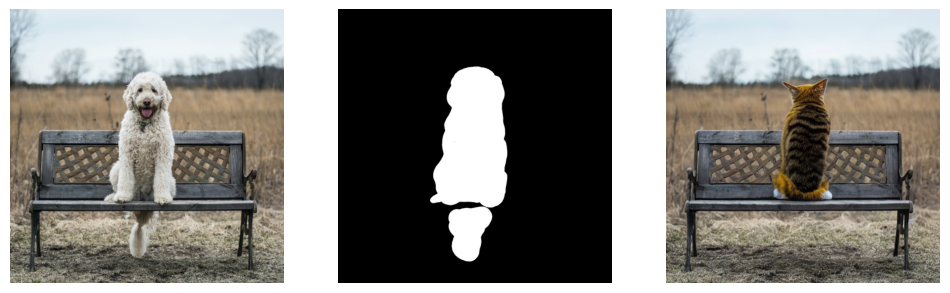

In [ ]:
import matplotlib.pyplot as plt

# 실행 결과를 plot
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(init_image)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(mask_image)
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(image)
plt.show()

# Personalization : 자신만의 Diffusion Model 만들기
- Personalization : 개인이 소유한 사진을 디퓨전 모델에 넣어서 사용할 수는 없을까?
## Dreambooth
- 하나의 객체에 대한 3-5 장 정도의 이미지로 디퓨전 모델을 파인튜닝
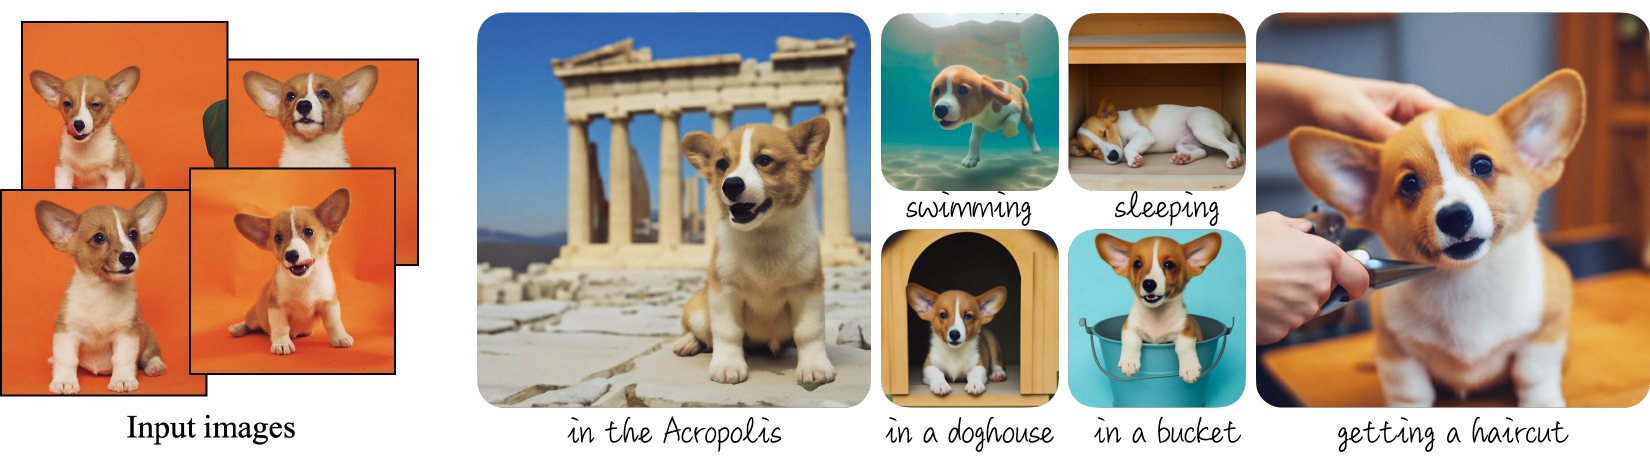

## Textual Inversion
- 하나의 객체에 대한 이미지를 입력하여 디퓨전 모델만이 이해할 수 있는 특별한 단어를 학습
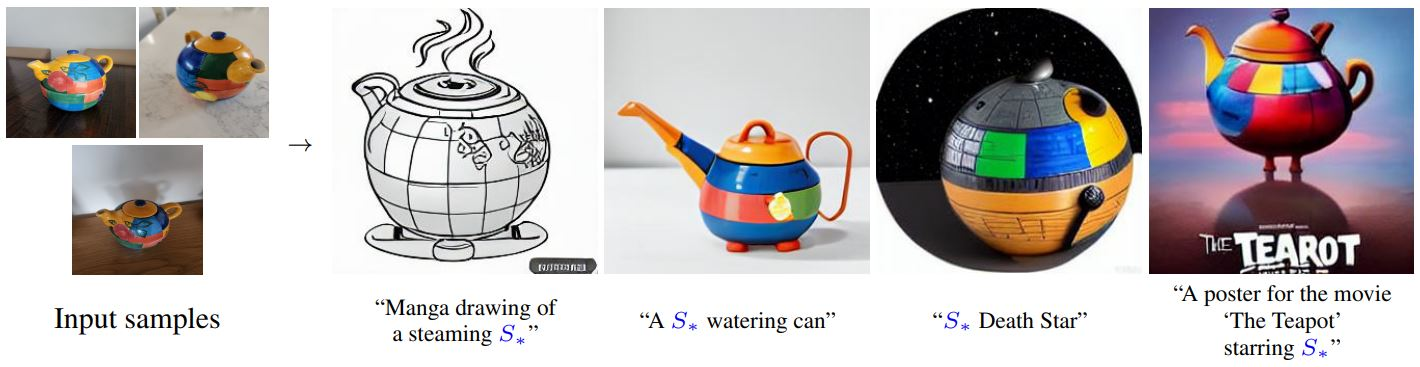

# manual seed(1024)를 이용하여 seed를 고정한 상태에서 negative prompt를 사용하여 수염이 없는 남자 사진을 만들기
- 사진을 생성할 때, 내가 원하지 않는 부분을 제외하고 만들고 싶다면?
- (positive) prompt, negative prompt를 이용하여 만드는 사진에 넣고 싶은 요소와 빼고 싶은 요소를 디퓨전 모델에 입력
- diffusers pipeline github https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py 참조
- prompt는 "a man wearing fedora"를 사용


In [ ]:
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import torch

# diffusion model의 이미지 생성 과정이 pipe 안에서 전부 이루어집니다.
# 이번 실습에서는 stable diffusion 1.5를 사용
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
prompt = "a man wearing fedora"

# generator를 사용하여 시드값 설정 : 1024
generator = torch.Generator("cuda").manual_seed(1024)
image_beard = pipe(prompt, guidance_scale=7.5, generator=generator).images[0]


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
prompt = "a man wearing fedora"
negative_prompt = "beard"
# generator를 사용하여 시드값 설정 : 1024
generator = torch.Generator("cuda").manual_seed(1024)
image_nobeard = pipe(prompt, negative_prompt=negative_prompt, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

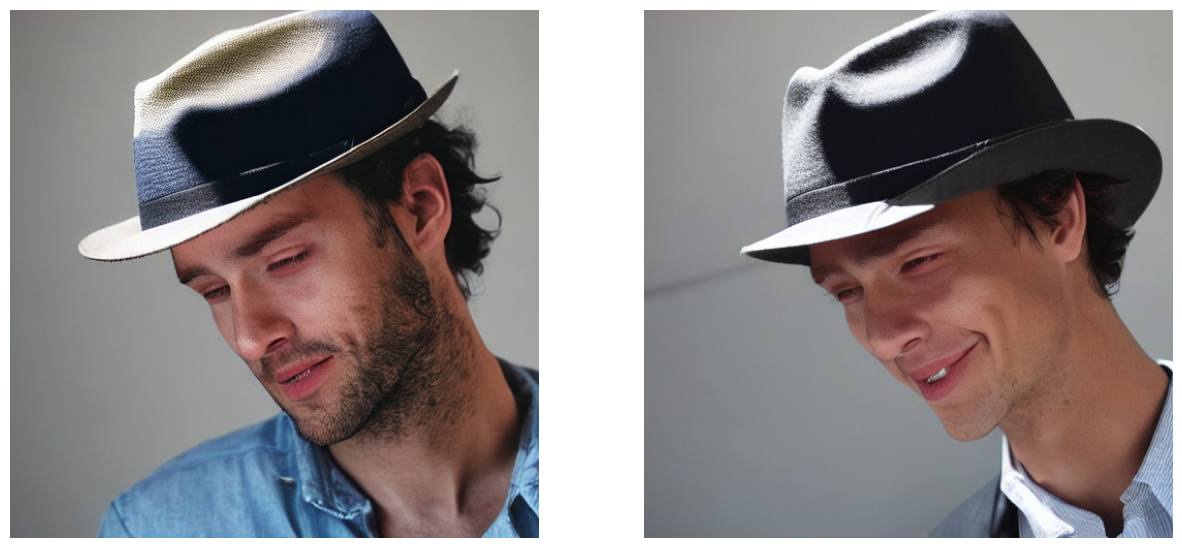

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image_beard)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image_nobeard)
plt.show()


2. 주어진 pose 사진을 사용하여 ControlNet으로 사진 생성하기
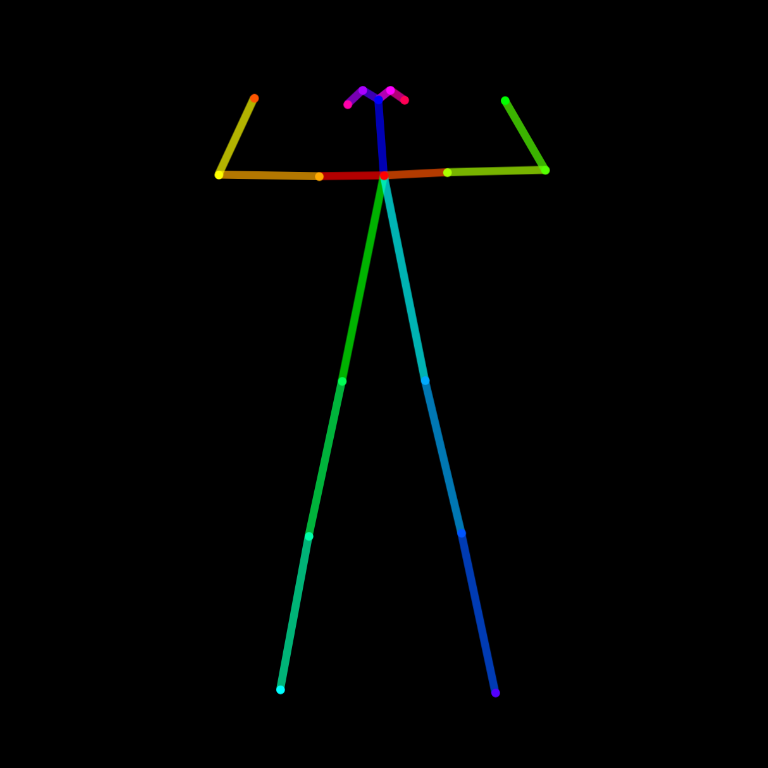

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

torch.cuda.empty_cache()

# diffusers에서 controlnet 모델을 불러올 때, sd-controlnet-openpose로 변경
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

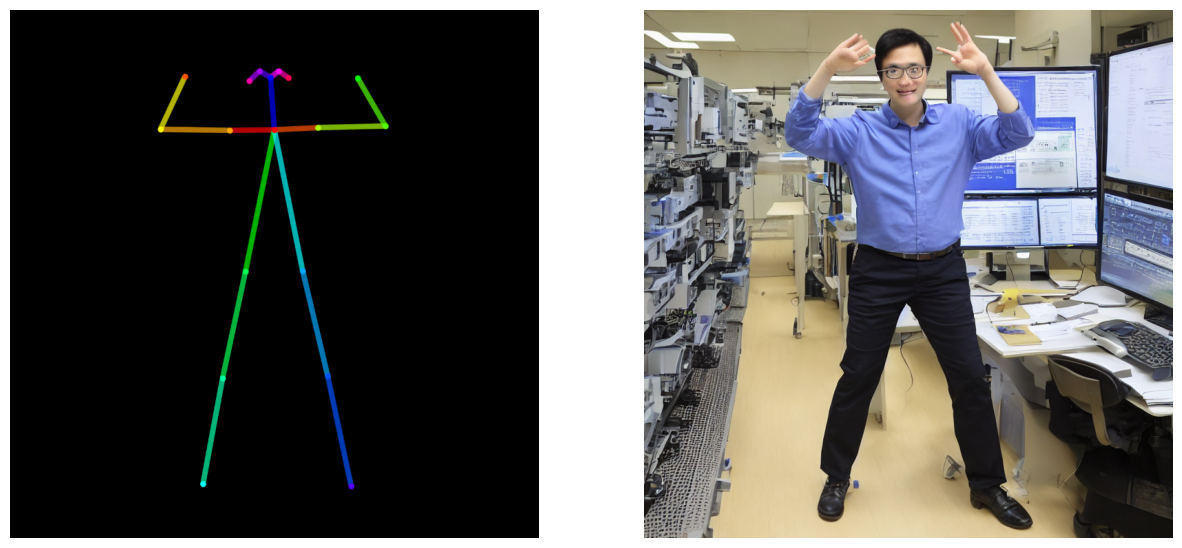

In [ ]:
# 스케치 사진을 불러옵니다.
scribble_image = Image.open('./pose.png')

prompt = "a professor who teaches artificial intelligence in the computer engineering department of a university in South Korea"

# pipeline에는 prompt, 스케치 이미지를 입력합니다.

output = pipe(
    prompt,
    scribble_image,
).images[0]

# 스케치 이미지와 생성 결과물을 plot합니다.
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(scribble_image)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(output)
plt.show()

3. inpainting 수행하기
- mask는 https://huggingface.co/spaces/r3gm/inpaint-mask-maker 에서 마스크를 직접 생성

In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline
import PIL
import requests
from io import BytesIO

torch.cuda.empty_cache()

# inpainting pipeline 불러오기
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
# url로부터 예시 이미지를 다운로드하고 512 x 512 크기로 맞추기
img = Image.open('./inpainting.jpeg')
mask = Image.open('./inpainting_mask.png')

init_image = img.resize((512, 512))
mask_image = mask.resize((512, 512))

  0%|          | 0/50 [00:00<?, ?it/s]

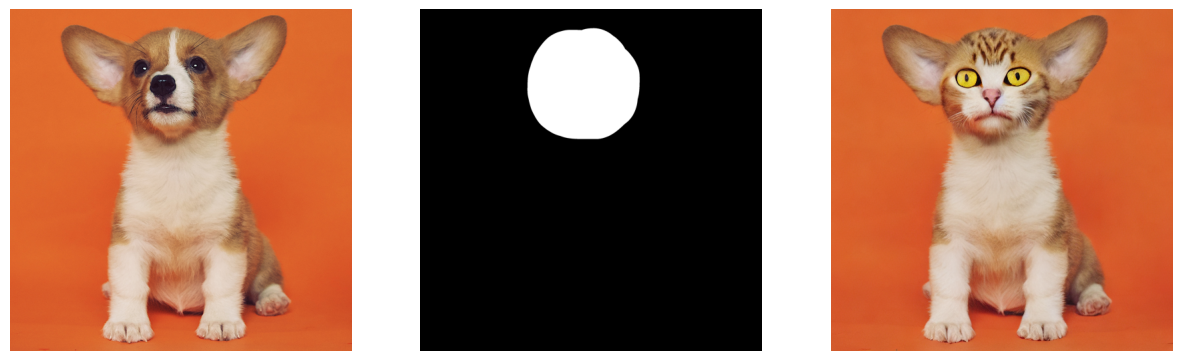

In [ ]:
prompt = "Face of a yellow cat, high resolution, sitting on a park bench"

# 파이프라인에는 프롬프트, 원본 이미지, 마스크 이미지를 입력합니다.
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

import matplotlib.pyplot as plt

# 실행 결과를 plot
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(init_image)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(mask_image)
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(image)
plt.show()